In [44]:
'''
투자자 분석
1. 초기 투자를 잘 하는 작은 규모의 투자자를 찾아보자
2. Top10, 25 들이랑 같이 들어가는 투자자들을 찾아보자
'''

'\n\xed\x88\xac\xec\x9e\x90\xec\x9e\x90 \xeb\xb6\x84\xec\x84\x9d\n1. \xec\xb4\x88\xea\xb8\xb0 \xed\x88\xac\xec\x9e\x90\xeb\xa5\xbc \xec\x9e\x98 \xed\x95\x98\xeb\x8a\x94 \xec\x9e\x91\xec\x9d\x80 \xea\xb7\x9c\xeb\xaa\xa8\xec\x9d\x98 \xed\x88\xac\xec\x9e\x90\xec\x9e\x90\xeb\xa5\xbc \xec\xb0\xbe\xec\x95\x84\xeb\xb3\xb4\xec\x9e\x90\n2. Top10, 25 \xeb\x93\xa4\xec\x9d\xb4\xeb\x9e\x91 \xea\xb0\x99\xec\x9d\xb4 \xeb\x93\xa4\xec\x96\xb4\xea\xb0\x80\xeb\x8a\x94 \xed\x88\xac\xec\x9e\x90\xec\x9e\x90\xeb\x93\xa4\xec\x9d\x84 \xec\xb0\xbe\xec\x95\x84\xeb\xb3\xb4\xec\x9e\x90\n'

In [1]:
import pandas as pd
import re
import gensim
import pickle
import numpy as np
import operator
from datetime import datetime
from matplotlib import pyplot as plt
import networkx as nx
from copy import copy
%matplotlib inline

In [2]:
# load data
data_folder = '../data/csv_export/'
util_folder = '../util/'
df_organizations = pd.read_csv(data_folder + 'organizations.csv'.format(data_folder), dtype={'first_funding_on': str, 'last_funding_on':str})
df_description = pd.read_csv(data_folder + 'organization_descriptions.csv')
df_funding_rounds = pd.read_csv(data_folder + 'funding_rounds.csv')
df_funds = pd.read_csv(data_folder + 'funds.csv')
df_investments = pd.read_csv(data_folder + 'investments.csv')
df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
df_people = pd.read_csv(data_folder + 'people.csv')
df_degrees = pd.read_csv(data_folder + 'degrees.csv')
df_investors = pd.read_csv(data_folder + 'investors.csv')
df_country_code = pd.read_csv(util_folder + 'country_code.csv', delimiter = '\t')

In [85]:
print df_funding_rounds.shape
print df_funding_rounds.head()

(174456, 25)
         company_name country_code state_code  region    city  \
0            Instarem          SGP        NaN     NaN     NaN   
1                Tide          GBR        NaN  London  London   
2            UrbanYou          AUS        NaN  Sydney  Sydney   
3  Antag Therapeutics          NaN        NaN     NaN     NaN   
4   Bellamy's Organic          NaN        NaN     NaN     NaN   

                               company_category_list funding_round_type  \
0                         Financial Services|FinTech            venture   
1  Financial Services|Identity Management|Mobile ...            venture   
2     Consumer|Customer Service|Information Services            venture   
3                                                NaN               seed   
4                                                NaN            venture   

  funding_round_code announced_on  raised_amount_usd  \
0                  B   2017-07-04         13000000.0   
1                  A   2017-07-04

In [8]:
'''
1. 초기 투자를 잘 하는 투자자를 찾아보자
'''

# 잘된 회사를 찾기
def get_investor_scores(investment_criteria = ['A', 'B', 'C', 'D'], success_criteria = ['acquisition', 'ipo'], founded_after_this = '2007-01-01', founded_before_this = '2020-01-01',  asia_only = False, words = None, expand = False):    
    if words is not None:
        # load dataset
        if 'word2company' not in globals():
            print('loading word2company')
            global word2company
            word2company = pickle.load(open(util_folder + 'word2company.pickle'))
        if 'model' not in globals():
            print('loading word2vec model')
            global model
            model = gensim.models.word2vec.Word2Vec.load(util_folder + 'word2vec')

        # expand word set if necessary
        # train 된 word2vec 을 사용하여 관련도가 높은 단어들을 포함한다
        final_words = []
        if type(words) == str:
            words = [words]
        for word in words:
            if ' ' in word:
                word = word.replace(' ', '_')
            if expand:
                _words = model.most_similar(word)
                _words = [str(_word) for _word, sim in _words]
                final_words.extend(_words)
            final_words.append(word)
        final_words = list(set(final_words))    

        # choose companies that have relevant words
        companies = []
        for word in final_words:
            _companies = word2company.get(word, [])
            companies.extend(_companies)
        companies = list(set(companies))    
    
    # get all companies founded after the time
    df_organizations['founded_on'] = pd.to_datetime(df_organizations['founded_on'], errors='ignore')
    df = df_organizations.copy()
    df = df[df['founded_on'] >= founded_after_this]
    df = df[df['founded_on'] <= founded_before_this]
    
    # filter by words if necessary
    if words is not None:
        df = df[df['uuid'].isin(companies)]
#         companies = df_companies[df_companies['founded_on'] >= founded_after_this]
    companies = df        
    
    # 아시아 회사에 대해서만
    if asia_only:
        print('before {}'.format(len(companies)))
        asia = df_country_code[df_country_code['CC'] == 'AS']['a-3'].values
        companies = companies[companies['country_code'].isin(asia)]
        print('after {}'.format(len(companies)))
    companies = companies['uuid']
    print('There are {} companies founded from {} to {}'.format(len(companies), founded_after_this, founded_before_this))

    # get good companies with correct funding criteria        
    fundings = df_funding_rounds[df_funding_rounds['company_uuid'].isin(companies)]
    good_companies_1 = fundings[fundings['funding_round_code'].isin(success_criteria)]['company_uuid'].values
    good_companies_1 = list(set(good_companies_1))
    print('{} companies with late stage fundings'.format(len(good_companies_1)))
    
    # Get list of acquired companies
    if 'acquisition' in success_criteria:        
        df_acq = pd.read_csv(data_folder + 'acquisitions.csv')
#         df_acq = df_acq[df_acq['price_usd'] > 1000000]
        df_acq = df_acq[df_acq['acquiree_uuid'].isin(companies)]
        print('{} acquired for 1M+'.format(df_acq.shape[0], len(companies)))
        good_companies_2 = df_acq['acquiree_uuid'].values
        good_companies_2 = list(set(good_companies_2))
    
    # Get list of IPO companies
    if 'ipo' in success_criteria:
        df_ipos = pd.read_csv(data_folder + 'ipos.csv')
        df_ipos = df_ipos[df_ipos['company_uuid'].isin(companies)]
        print('{} IPOs'.format(df_ipos.shape[0]))
        good_companies_3 = df_ipos['company_uuid'].values
        good_companies_3 = list(set(good_companies_3))
    
    # combine all good companies
    good_companies = good_companies_1
    if 'acquisition' in success_criteria:
        good_companies.extend(good_companies_2)
    if 'ipo' in success_criteria:
        good_companies.extend(good_companies_3)
    good_companies = list(set(good_companies))
    print('In total, {} good companies'.format(len(good_companies)))
    
    if 'seed' in investment_criteria:
        early_funding = pd.concat([fundings[fundings['funding_round_type'] == 'seed'],
                                   fundings[fundings['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()
    else:
        early_funding = pd.concat([fundings[fundings['funding_round_code'].isin(investment_criteria)]], axis = 0).reset_index()

    # good fundings
    all_seed = early_funding[early_funding['company_uuid'].isin(companies)]['funding_round_uuid'].values
    all_seed = list(set(all_seed))
    good_seed = early_funding[early_funding['company_uuid'].isin(good_companies)]['funding_round_uuid'].values
    good_seed = list(set(good_seed))
    print('# good companies: {} with {}\n# good / all early investments: {} / {}'.format(len(good_companies), success_criteria, len(good_seed), len(all_seed)))

    # good investors
    investor_score_good = {}
    investor_score_all = {}
    investor_score = {}

    good_investment_count = df_investments[df_investments['funding_round_uuid'].isin(good_seed)].groupby('investor_uuid')['funding_round_uuid'].count()
    all_investment_count = df_investments[df_investments['funding_round_uuid'].isin(all_seed)].groupby('investor_uuid')['funding_round_uuid'].count()
    
    return good_investment_count, all_investment_count
#     return good_investment_count.to_dict(), all_investment_count.to_dict()

In [48]:
'''
초기 투자 잘 하는 투자자들 중 어떤 규모의 투자자들을 보고 싶은가?
'''
    
def check(investor_score_good, investor_score_all, MIN_SEED = 10, MAX_SEED = 20):
    print('MIN: {} MAX: {}'.format(MIN_SEED, MAX_SEED))
#     score = investor_score_good / investor_score_all
    score = pd.concat([investor_score_good / investor_score_all, investor_score_good, investor_score_all], axis = 1)
    score = score.reset_index()
    score.columns = ['uuid', 'prob', 'good', 'all']
    score = score.merge(df_investors[['investor_name', 'uuid']], how = 'inner', on = 'uuid')
    
#     print score.head()
    score = score.drop('uuid', axis = 1)
    score = score[score['all'] > MIN_SEED]
    score = score[score['all'] <= MAX_SEED]
    score = score.sort_values(['prob', 'all'], ascending = [False, False])

#     score = score.to_string(index = False)
    print(score.head(20).to_csv(sep='\t', index=False))

#     print score
    
#     investor_score_good = investor_score_good.to_dict()
#     investor_score_all = investor_score_all.to_dict()
#     investor_score = {}
#     for investor, all_count in investor_score_all.items():
# #         if all_count >= MIN_SEED:
#         if all_count <= MIN_SEED:    
#             investor_score[investor]= investor_score_good.get(investor, 0) / float(all_count)

#     investor_score = sorted(investor_score.items(), key=operator.itemgetter(1))
#     investor_score.reverse()
#     print('{} investors with minimum of {} seed investment').format(len(investor_score), MIN_SEED)
#     for investor, score in investor_score[:30]:
#         try:
#             print('{:.3f}={}/{}\t{}'.format(score, investor_score_good[investor], investor_score_all[investor], df_investors[df_investors['uuid'] == investor]['investor_name'].values[0]))
#         except Exception as e:
#             print('no investor name')

In [49]:
def graph(good_investments, all_investments):
    score_investments = good_investments / all_investments
    log_good_investments = good_investments.apply(lambda x: np.log(x + 1))
    log_all_investments = all_investments.apply(lambda x: np.log(x + 1))
    data = pd.concat([all_investments, good_investments, score_investments], axis = 1)
    data.columns = ['all', 'good', 'score']
#     data.plot(x = 'all', y = 'good', kind = 'scatter', xlim = (0, 1000), ylim = (0, 1000), loglog = True)
    
#     nums = [0, 1, 10,30,100, 300, 1000, 3000, 10000]
    nums = [0, 1, 10,30,100, 300, 1000, 3000, 10000]
    nums = [2 ** (i - 1) for i in range(13)]
    group_names = []
    for i in range(len(nums) - 1):
        group_names.append('{} ~ {}'.format(nums[i], nums[i + 1]))
    
    data['categories'] = pd.cut(data['all'], nums, labels=group_names)
    scores = []
    for group in group_names:
        good = data[data['categories'] == group]['good'].sum()
        _all = data[data['categories'] == group]['all'].sum()
        if _all > 0:
            print group, good / float(_all), int(good), _all
            scores.append(good / float(_all))
#     print data.head(30)
    data_to_plot = pd.concat([pd.Series(scores), pd.Series(group_names)], axis = 1)
    data_to_plot.columns = ['success probability', 'number of investments']
    data_to_plot.plot.bar(x = 'number of investments', y = 'success probability', figsize = (10, 6))
    

There are 165482 companies founded from 2007-01-01 to 2014-01-01
0 companies with late stage fundings
9535 acquired for 1M+
1381 IPOs
In total, 10682 good companies
# good companies: 10682 with ['acquisition', 'ipo']
# good / all early investments: 1835 / 12191
0.5 ~ 1 0.130202774813 732 5622
1 ~ 2 0.136106623586 337 2476
2 ~ 4 0.143112701252 400 2795
4 ~ 8 0.155403695267 614 3951
8 ~ 16 0.167860553964 703 4188
16 ~ 32 0.172459893048 645 3740
32 ~ 64 0.223761157279 727 3249
64 ~ 128 0.241678726483 501 2073
128 ~ 256 0.257641921397 236 916


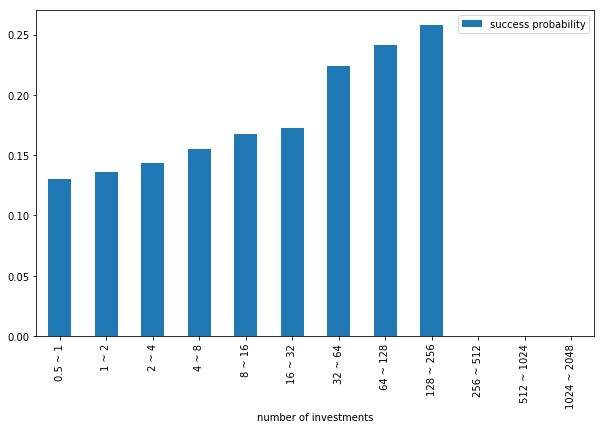

In [59]:
investment_criteria = ['A']
success_criteria = ['acquisition', 'ipo']
founded_after_this = '2007-01-01'
founded_before_this = '2014-01-01'
global_investor_score_good, global_investor_score_all = get_investor_scores(investment_criteria, success_criteria, founded_after_this, founded_before_this, False)
graph(global_investor_score_good, global_investor_score_all)

In [10]:
# investment_criteria = ['seed', A', 'B', 'C', 'D']
# investment_criteria = ['seed']
# investment_criteria = ['A']
# investment_criteria = ['B']
# investment_criteria = ['C']
investment_criteria = ['A', 'B', 'C']
success_criteria = ['acquisition', 'ipo']
founded_after_this = '2007-01-01'
founded_before_this = '2014-01-01'
global_investor_score_good, global_investor_score_all = get_investor_scores(investment_criteria, success_criteria, founded_after_this, founded_before_this, False)
asia_investor_score_good, asia_investor_score_all = get_investor_scores(investment_criteria, success_criteria, founded_after_this, founded_before_this, True)

There are 165482 companies founded from 2007-01-01 to 2014-01-01
0 companies with late stage fundings
9535 acquired for 1M+
1381 IPOs
In total, 10682 good companies
# good companies: 10682 with ['acquisition', 'ipo']
# good / all early investments: 3202 / 20015
before 165482
after 20568
There are 20568 companies founded from 2007-01-01 to 2014-01-01
0 companies with late stage fundings
813 acquired for 1M+
138 IPOs
In total, 929 good companies
# good companies: 929 with ['acquisition', 'ipo']
# good / all early investments: 246 / 3458


In [11]:
# global 투자자, 최소 5개의 seed 투자
check(global_investor_score_good, global_investor_score_all, MIN_SEED = 5, MAX_SEED = 50)
check(global_investor_score_good, global_investor_score_all, MIN_SEED = 20, MAX_SEED = 200)
check(global_investor_score_good, global_investor_score_all, MIN_SEED = 100, MAX_SEED = 1000)

# global 투자자, 최소 5개의 seed 투자
check(asia_investor_score_good, asia_investor_score_all, MIN_SEED = 3, MAX_SEED = 25)
check(asia_investor_score_good, asia_investor_score_all, MIN_SEED = 5, MAX_SEED = 50)
check(asia_investor_score_good, asia_investor_score_all, MIN_SEED = 20, MAX_SEED = 1000)

MIN: 5 MAX: 50
prob	good	all	investor_name
1.0	8.0	8	HBM BioVentures
1.0	6.0	6	Brian Pokorny
1.0	6.0	6	Big Bang Ventures
0.875	7.0	8	Jennison Associates
0.866666666667	13.0	15	Aisling Capital
0.833333333333	5.0	6	Sprout Group
0.833333333333	5.0	6	Michael Parekh
0.833333333333	5.0	6	YL Ventures
0.833333333333	5.0	6	MP Healthcare Venture Management
0.8	8.0	10	Glilot Capital Partners
0.777777777778	7.0	9	Casdin Capital
0.75	15.0	20	Rock Springs Capital
0.75	6.0	8	Labrador Ventures
0.739130434783	17.0	23	MPM Capital
0.727272727273	8.0	11	HealthCare Ventures
0.714285714286	5.0	7	Partner Fund Management
0.714285714286	5.0	7	Remeditex Ventures
0.714285714286	5.0	7	Lemhi Ventures
0.7	7.0	10	Roger Ehrenberg
0.6875	11.0	16	Bay City Capital

MIN: 20 MAX: 200
prob	good	all	investor_name
0.739130434783	17.0	23	MPM Capital
0.620689655172	18.0	29	VantagePoint Capital Partners
0.545454545455	18.0	33	RA Capital Management
0.545454545455	12.0	22	Boulder Ventures
0.540540540541	20.0	37	New Leaf Venture P

In [12]:
word = 'iot'
# investment_criteria = ['A', 'B', 'C', 'D'], success_criteria = ['acquisition', 'ipo'], founded_after_this = '2007-01-01', founded_before_this = '2020-01-01',  asia_only = False, words = None, expand = False
specific_global_investor_score_good, specific_global_investor_score_all = get_investor_scores(investment_criteria, success_criteria, founded_after_this, '2020-01-01', False, word, False)
check(specific_global_investor_score_good, specific_global_investor_score_all, MIN_SEED = 2)

loading word2company
loading word2vec model
There are 798 companies founded from 2007-01-01 to 2020-01-01
0 companies with late stage fundings
27 acquired for 1M+
3 IPOs
In total, 30 good companies
# good companies: 30 with ['acquisition', 'ipo']
# good / all early investments: 2 / 139
MIN: 2 MAX: 20
prob	good	all	investor_name
0.666666666667	2.0	3	Khosla Ventures
		4	Bain Capital Ventures
		4	True Ventures
		3	Mantella Venture Partners
		3	First Round
		3	Two Sigma Ventures
		3	Kepha Partners
		3	New Leaf Venture Partners
		3	Earlybird Venture Capital
		3	Hyde Park Angels
		3	Easton Capital
		3	Crosslink Capital
		3	LionBird
		3	Sigma Partners
		3	GE Ventures
		3	Voyager Capital
		3	Sands Capital Ventures
		3	Redpoint
		3	Greylock Partners
		3	Inventure Oy



In [13]:
word = 'deep_learning'
specific_global_investor_score_good, specific_global_investor_score_all = get_investor_scores(investment_criteria, success_criteria, founded_after_this, '2020-01-01', False, word, False)
check(specific_global_investor_score_good, specific_global_investor_score_all, MIN_SEED = 2)

There are 203 companies founded from 2007-01-01 to 2020-01-01
0 companies with late stage fundings
10 acquired for 1M+
0 IPOs
In total, 10 good companies
# good companies: 10 with ['acquisition', 'ipo']
# good / all early investments: 4 / 47
MIN: 2 MAX: 20
prob	good	all	investor_name
0.666666666667	2.0	3	Allen & Company
0.666666666667	2.0	3	Draper Fisher Jurvetson (DFJ)
0.333333333333	1.0	3	Data Collective
		4	Vertex Ventures



In [14]:
word = 'drone'
specific_global_investor_score_good, specific_global_investor_score_all = get_investor_scores(investment_criteria, success_criteria, founded_after_this, '2020-01-01', False, word, False)
check(specific_global_investor_score_good, specific_global_investor_score_all, MIN_SEED = 2)

There are 244 companies founded from 2007-01-01 to 2020-01-01
0 companies with late stage fundings
4 acquired for 1M+
3 IPOs
In total, 7 good companies
# good companies: 7 with ['acquisition', 'ipo']
# good / all early investments: 1 / 35
MIN: 2 MAX: 20
prob	good	all	investor_name
		4	Qualcomm Ventures
		4	SK Ventures
		3	ZhenFund
		3	Oreilly AlphaTech Ventures
		3	ff Venture Capital
		3	Menlo Ventures
		3	Accel Partners
		3	GGV Capital
		3	True Ventures



In [15]:
'''
2. 유명한 투자자들과 인맥이 있을 것 같은 작은 투자자들을 살펴보자
'''

# get investors with high centrality
f = open(util_folder + 'investor_centrality_degree.pickle')
investors_high_central = pickle.load(f)
f.close()

In [21]:
# 유명한 회사들 찾기 1 (network centrality)
top25 = [uuid for uuid, value in investors_high_central[:25]]
top25_central = []
for i, uuid in enumerate(top25):
    print('{}\t{}'.format(df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], investors_high_central[i][1]))
    top25_central.append(uuid)

500 Startups	0.0645051194539
New Enterprise Associates	0.0460750853242
SV Angel	0.0447886584405
Intel Capital	0.0431346810186
Y Combinator	0.0369650826989
Accel Partners	0.035914938304
Kleiner Perkins Caufield & Byers	0.034287214492
Sequoia Capital	0.0339459175637
GV	0.0312943029667
First Round	0.0301916513521
Goldman Sachs	0.0284589131006
Greylock Partners	0.028170123392
Bessemer Venture Partners	0.0279075872933
Andreessen Horowitz	0.0277238120242
Draper Fisher Jurvetson (DFJ)	0.0273825150958
Index Ventures	0.0267786820688
Great Oaks Venture Capital	0.0244683644001
Lerer Hippeau Ventures	0.024284589131
CrunchFund	0.0241795746915
Khosla Ventures	0.0237857705434
General Catalyst	0.0236545024941
Felicis Ventures	0.0235494880546
RRE Ventures	0.0227881333683
BoxGroup	0.0219480178525
Menlo Ventures	0.0213179312155


In [22]:
# 유명한 회사들 찾기 2. funding frequency
groups = df_investments.groupby('investor_uuid')['funding_round_uuid'].count().reset_index().sort_values(by = 'funding_round_uuid', ascending = False)#['investor_uuid'].apply(list)
count = 0
top25_funding = []
for index, row in groups.iterrows():
    uuid = row[0]
    fund_count = row[1]
    print('{}\t{}'.format(df_investors[df_investors['uuid'] == (uuid)]['investor_name'].values[0], fund_count))
    top25_funding.append(uuid)
    if count == 25: break
    count += 1

500 Startups	1518
Sequoia Capital	1432
Y Combinator	1344
New Enterprise Associates	1328
Intel Capital	1179
Accel Partners	1078
NYSERDA	1004
Kleiner Perkins Caufield & Byers	968
Wayra	952
SOSV	950
Draper Fisher Jurvetson (DFJ)	782
Start-Up Chile	745
SV Angel	738
Bessemer Venture Partners	712
Techstars	691
Right Side Capital Management	661
Greylock Partners	592
First Round	580
Index Ventures	573
Goldman Sachs	571
Lightspeed Venture Partners	558
Battery Ventures	556
Brand Capital	553
High-Tech Gruenderfonds	551
Plug and Play	543
Venrock	538


There are 165482 companies founded from 2007-01-01 to 2014-01-01
0 companies with late stage fundings
9535 acquired for 1M+
1381 IPOs
In total, 10682 good companies
# good companies: 10682 with ['acquisition', 'ipo']
# good / all early investments: 1835 / 12191
investor_uuid
0026bf40-8f42-87e2-b371-978055165959    1
00512295-30cd-2ec6-2ded-ea51b3aed16d    3
00744f0e-2a23-db04-0507-9417a719da13    1
00bf0829-3aad-0d93-2d28-9249d8806cbd    1
0159561f-be5d-81eb-7ccd-b4d6efeb30fc    3
Name: funding_round_uuid, dtype: int64
There are 520408 companies
                          investor_uuid  all_early  good_early     score  \
0  00512295-30cd-2ec6-2ded-ea51b3aed16d         36        16.0  0.444444   
1  0159561f-be5d-81eb-7ccd-b4d6efeb30fc         13         9.0  0.692308   
2  01a1fa1f-c36c-91c2-3572-1b8c51796a7b         55        17.0  0.309091   
3  01b78c00-b6e2-7cbc-8286-8d14d09d441e         39        13.0  0.333333   
4  01ca973a-cb9f-c268-40f3-d178e8ba0cf7         25         6.0  0.24

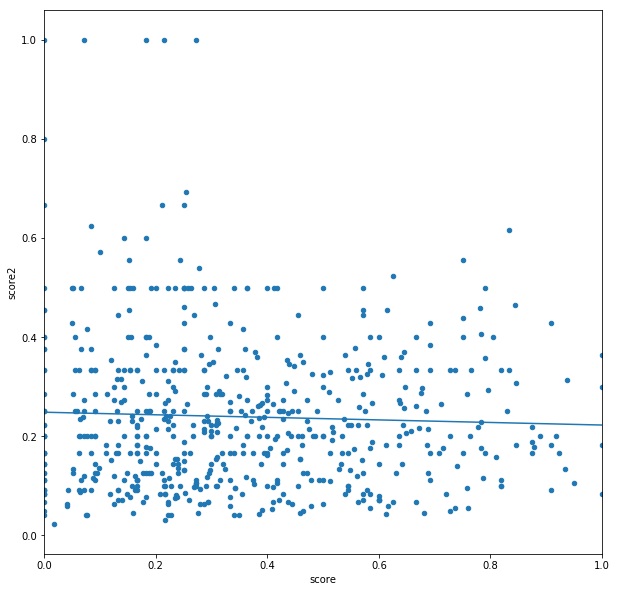

In [84]:
# 유명한 회사들과 공동 투자를 많이 한 회사를 찾아라
# 그 중 최소한 MIN 번 이상의 투자를 한 회사들
MIN = 10
early_criteria = ['A']

investment_criteria = early_criteria
success_criteria = ['acquisition', 'ipo']
founded_after_this = '2007-01-01'
founded_before_this = '2014-01-01'
global_investor_score_good, global_investor_score_all = get_investor_scores(investment_criteria, success_criteria, founded_after_this, founded_before_this, False)
print(global_investor_score_good.head())

# get all companies founded after the time
companies = df_organizations['uuid']
print('There are {} companies'.format(len(companies)))

# get famous investors
top_investors = top25_central
top_investors.extend(top25_funding)
top_investors = list(set(top_investors))

# get funding_round_uuid from top_investors from df_investments
funding_round_from_top_vc = df_investments[df_investments['investor_uuid'].isin(top_investors)]['funding_round_uuid'].values

# get company_uuid from funding_round_uuid from df_funding_rounds
companies_funded_by_top_vc = df_funding_rounds[df_funding_rounds['funding_round_uuid'].isin(funding_round_from_top_vc)]['company_uuid'].values

# get seed, A funding_round from company_uuid from funding_rounds
# early_all_funding_rounds = pd.concat([df_funding_rounds[df_funding_rounds['funding_round_type'] == 'seed'],
#                           df_funding_rounds[df_funding_rounds['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values
# df = df_funding_rounds[df_funding_rounds['company_uuid'].isin(companies_funded_by_top_vc)]
# early_good_funding_rounds = pd.concat([df[df['funding_round_type'] == 'seed'],
#                           df[df['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values
early_all_funding_rounds = pd.concat([df_funding_rounds[df_funding_rounds['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values
df = df_funding_rounds[df_funding_rounds['company_uuid'].isin(companies_funded_by_top_vc)]
early_good_funding_rounds = pd.concat([df[df['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values


# get counts from early_funding_rounds from df_investments
count = pd.concat([df_investments[df_investments['funding_round_uuid'].isin(early_all_funding_rounds)].groupby('investor_uuid')['funding_round_uuid'].count().rename('all_early'),
                   df_investments[df_investments['funding_round_uuid'].isin(early_good_funding_rounds)].groupby('investor_uuid')['funding_round_uuid'].count().rename('good_early')],
                  axis = 1).reset_index()
count = count.fillna(0)
count = count[count['all_early'] > MIN]
count = count.rename(columns = {'index': 'investor_uuid'})
count = count[~count['investor_uuid'].isin(top_investors)]
count['score'] = count['good_early'] / count['all_early']

_all = global_investor_score_all.to_frame().reset_index()
good = global_investor_score_good.to_frame().reset_index()
_all.columns = ['investor_uuid', 'all2']
good.columns = ['investor_uuid', 'good2']
# # print _all.head()
# print global_investor_score_good.to_frame().reset_index().head()
count = count.merge(good, on = 'investor_uuid', how = 'inner')
count = count.merge(_all, on = 'investor_uuid', how = 'inner')

count['score2'] = count['good2'] / count['all2']
print count.head()
# global_investor_score_good

count = count.merge(df_investors, left_on = 'investor_uuid', right_on = 'uuid')
count = count.sort_values(['score', 'all_early'], ascending = False)
count = count[['investor_name', 'all_early', 'good_early', 'score', 'score2']]
count = count.reset_index()
# count = count.drop('index')
print count.head(50).to_csv(sep = '\t')

# count.plot(x = 'score', y = 'score2', kind = 'scatter')
z = np.polyfit(x=count.loc[:, 'score'], y=count.loc[:, 'score2'], deg=1)
p = np.poly1d(z)
# print count.columns
count['trendline'] = p(count.loc[:, 'score'])

ax = count.plot.scatter(x='score', y='score2')
count.set_index('score', inplace=True)
count.trendline.sort_index(ascending=False).plot(ax=ax, figsize = (10, 10))
plt.gca().invert_xaxis()




There are 165482 companies founded from 2007-01-01 to 2014-01-01
0 companies with late stage fundings
9535 acquired for 1M+
1381 IPOs
In total, 10682 good companies
# good companies: 10682 with ['acquisition', 'ipo']
# good / all early investments: 2620 / 31248
investor_uuid
000c5688-ea1a-1abd-ed38-a36ad1fc47c8         NaN
00121759-7d9c-dc31-d0a7-60581cb33bb9         NaN
00122598-4cf3-0a67-a91e-b1df72d8ee46    0.666667
00197b5a-3456-9d09-14da-be6817a3a7fd         NaN
001e860c-6579-9835-b294-af1a65842ca9         NaN
Name: funding_round_uuid, dtype: float64
investor_uuid
000c5688-ea1a-1abd-ed38-a36ad1fc47c8    1
00121759-7d9c-dc31-d0a7-60581cb33bb9    1
00122598-4cf3-0a67-a91e-b1df72d8ee46    3
00197b5a-3456-9d09-14da-be6817a3a7fd    1
001e860c-6579-9835-b294-af1a65842ca9    1
Name: funding_round_uuid, dtype: int64
                                        score2  score
investor_uuid                                        
000c5688-ea1a-1abd-ed38-a36ad1fc47c8       NaN      1
00121759-7d9c

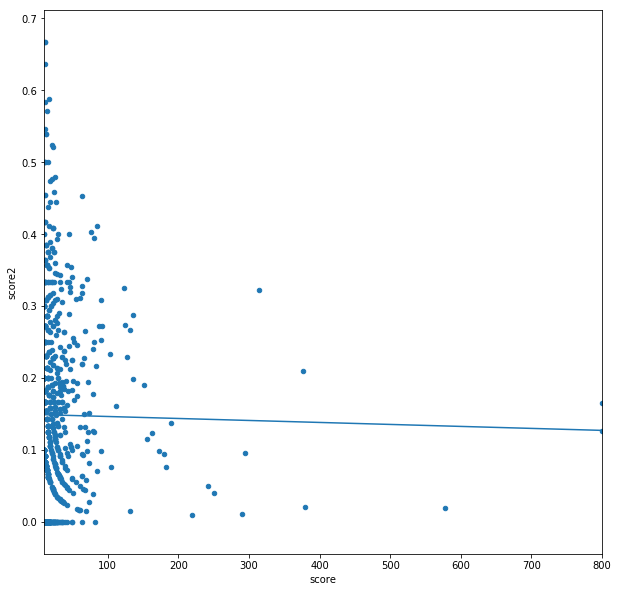

In [46]:
# 유명한 회사들과 공동 투자를 많이 한 회사를 찾아라
# 그 중 최소한 MIN 번 이상의 투자를 한 회사들
MIN = 10
early_criteria = ['seed']
# early_criteria = ['A']

investment_criteria = early_criteria
success_criteria = ['acquisition', 'ipo']
founded_after_this = '2007-01-01'
founded_before_this = '2014-01-01'
global_investor_score_good, global_investor_score_all = get_investor_scores(investment_criteria, success_criteria, founded_after_this, founded_before_this, False)


# # get all companies founded after the time
# companies = df_organizations['uuid']
# print('There are {} companies'.format(len(companies)))

# # get famous investors
# top_investors = top25_central
# top_investors.extend(top25_funding)
# top_investors = list(set(top_investors))

# # get funding_round_uuid from top_investors from df_investments
# funding_round_from_top_vc = df_investments[df_investments['investor_uuid'].isin(top_investors)]['funding_round_uuid'].values

# # get company_uuid from funding_round_uuid from df_funding_rounds
# companies_funded_by_top_vc = df_funding_rounds[df_funding_rounds['funding_round_uuid'].isin(funding_round_from_top_vc)]['company_uuid'].values

# # get seed, A funding_round from company_uuid from funding_rounds
# # early_all_funding_rounds = pd.concat([df_funding_rounds[df_funding_rounds['funding_round_type'] == 'seed'],
# #                           df_funding_rounds[df_funding_rounds['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values
# # df = df_funding_rounds[df_funding_rounds['company_uuid'].isin(companies_funded_by_top_vc)]
# # early_good_funding_rounds = pd.concat([df[df['funding_round_type'] == 'seed'],
# #                           df[df['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values
# early_all_funding_rounds = pd.concat([df_funding_rounds[df_funding_rounds['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values
# df = df_funding_rounds[df_funding_rounds['company_uuid'].isin(companies_funded_by_top_vc)]
# early_good_funding_rounds = pd.concat([df[df['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values


# # get counts from early_funding_rounds from df_investments
# count = pd.concat([df_investments[df_investments['funding_round_uuid'].isin(early_all_funding_rounds)].groupby('investor_uuid')['funding_round_uuid'].count().rename('all_early'),
#                    df_investments[df_investments['funding_round_uuid'].isin(early_good_funding_rounds)].groupby('investor_uuid')['funding_round_uuid'].count().rename('good_early')],
#                   axis = 1).reset_index()
# count = count.fillna(0)
# count = count[count['all_early'] > MIN]
# count = count.rename(columns = {'index': 'investor_uuid'})
# count = count[~count['investor_uuid'].isin(top_investors)]
# count['score'] = count['good_early'] / count['all_early']

# _all = global_investor_score_all.to_frame().reset_index()
# good = global_investor_score_good.to_frame().reset_index()
# _all.columns = ['investor_uuid', 'all2']
# good.columns = ['investor_uuid', 'good2']
# # # print _all.head()
# # print global_investor_score_good.to_frame().reset_index().head()
# count = count.merge(good, on = 'investor_uuid', how = 'inner')
# count = count.merge(_all, on = 'investor_uuid', how = 'inner')

# count['score2'] = count['good2'] / count['all2']
# print count.head()
# # global_investor_score_good

# count = count.merge(df_investors, left_on = 'investor_uuid', right_on = 'uuid')
# count = count.sort_values(['score', 'all_early'], ascending = False)
# count = count[['investor_name', 'all_early', 'good_early', 'score', 'score2']]
# count = count.reset_index()
# # count = count.drop('index')
# print count.head(50).to_csv(sep = '\t')

score1 = global_investor_score_good / global_investor_score_all
# score2 = df_investments.groupby('investor_uuid').size().reset_index()
score2 = global_investor_score_all
# score2.columns = ['investor_uuid', 'score2']
# print score2.shape
print score1.head()
print score2.head()

count = pd.concat([score1, score2], axis = 1)
count.columns = ['score2', 'score']
print count.head()
count = count[count['score'] >= MIN]
# count['score'] = np.log(count['score'])
print count.head()
count = count.fillna(0)

z = np.polyfit(x=count.loc[:, 'score'], y=count.loc[:, 'score2'], deg=1)
p = np.poly1d(z)
count['trendline'] = p(count.loc[:, 'score'])

ax = count.plot.scatter(x='score', y='score2')
count.set_index('score', inplace=True)
count.trendline.sort_index(ascending=False).plot(ax=ax, figsize = (10, 10))
plt.gca().invert_xaxis()
print z



# df_investments.head().groupby('investor_uuid').size()

In [ ]:
# co_funding_prop = {}
# print('TOP VC List')
# for investor1 in top_investors:
#     print('{}'.format(df_investors[df_investors['uuid'] == (investor1)]['investor_name'].values[0]))
    
# print('\n\n')
# for investor1 in top_investors:
#     co_funding_prop[investor1] = {}
#     for investor2, count in funding_count.items():
#         if count >= MIN:
#             if investor2 in co_funding_count[investor1]:
#                 co_funding_prop[investor1][investor2] = co_funding_count[investor1][investor2] / float(count)
#     # sort
#     score = co_funding_prop[investor1]
#     score = sorted(score.items(), key=operator.itemgetter(1))
#     score.reverse()
#     print('TOP VC {}'.format(df_investors[df_investors['uuid'] == (investor1)]['investor_name'].values[0]))
#     for key, value in score[:10]:
#         name = df_investors[df_investors['uuid'] == (key)]['investor_name'].values[0]
#         print('{}% {}: {}'.format(value * 100, funding_count[key], name))
#     print('\n\n')



# 유명한 회사들과 공동 투자를 많이 한 회사를 찾아라
# 그 중 최소한 MIN 번 이상의 투자를 한 회사들
MIN = 3
early_criteria = ['A']
                  
# get all companies founded after the time
companies = df_organizations['uuid']
print('There are {} companies'.format(len(companies)))

# get famous investors
_top_investors = top25_central
_top_investors.extend(top25_funding)
_top_investors = list(set(_top_investors))

for top_investor in _top_investors:
    top_investors = [top_investor]
#     print 'target VC: {}'.format(top_investor)
    print('{}'.format(df_investors[df_investors['uuid'] == (top_investor)]['investor_name'].values[0]))

    # get funding_round_uuid from top_investors from df_investments
    funding_round_from_top_vc = df_investments[df_investments['investor_uuid'].isin(top_investors)]['funding_round_uuid'].values

    # get company_uuid from funding_round_uuid from df_funding_rounds
    companies_funded_by_top_vc = df_funding_rounds[df_funding_rounds['funding_round_uuid'].isin(funding_round_from_top_vc)]['company_uuid'].values

    # get seed, A funding_round from company_uuid from funding_rounds
    early_all_funding_rounds = pd.concat([df_funding_rounds[df_funding_rounds['funding_round_type'] == 'seed'],
                              df_funding_rounds[df_funding_rounds['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values
    df = df_funding_rounds[df_funding_rounds['company_uuid'].isin(companies_funded_by_top_vc)]
    early_good_funding_rounds = pd.concat([df[df['funding_round_type'] == 'seed'],
                              df[df['funding_round_code'].isin(early_criteria)]], axis = 0).reset_index()['funding_round_uuid'].values

    # get counts from early_funding_rounds from df_investments
    count = pd.concat([df_investments[df_investments['funding_round_uuid'].isin(early_all_funding_rounds)].groupby('investor_uuid')['funding_round_uuid'].count().rename('all_early'),
                       df_investments[df_investments['funding_round_uuid'].isin(early_good_funding_rounds)].groupby('investor_uuid')['funding_round_uuid'].count().rename('good_early')],
                      axis = 1).reset_index()
    count = count.fillna(0)
    count = count[count['all_early'] > MIN]
    count = count.rename(columns = {'index': 'investor_uuid'})
    count = count[~count['investor_uuid'].isin(top_investors)]
    count['score'] = count['good_early'] / count['all_early']

    count = count.merge(df_investors, left_on = 'investor_uuid', right_on = 'uuid')
    count = count.sort_values(['score', 'all_early'], ascending = False)
    count = count[['investor_name', 'all_early', 'good_early', 'score']]
    print count.head(50).reset_index().to_csv(sep = '\t')